In [92]:
#Integrantes:
# María Tapia
# Mariela Gonzáles
# Jonathan Sánchez
# Master: Ciencias de Datos e Inteligencia Artificial

In [55]:
#Importar librerias necesarias para ejecutar los modelos y herraminetas necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from google.colab import drive
import os
from sklearn.neighbors import KNeighborsClassifier # Importar K-NN
from sklearn.ensemble import RandomForestClassifier # Importar Random Forest
from sklearn.svm import SVC # Importar SVM


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# Definir device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [57]:
# Definir la ruta base para guardar los archivos
base_output_path = 'drive/MyDrive/Colab Notebooks/red_convolucional_data/'

In [58]:
# Carga de datos
train_data = pd.read_csv('drive/MyDrive/Colab Notebooks/red_convolucional_data/train.csv')
test_data = pd.read_csv('drive/MyDrive/Colab Notebooks/red_convolucional_data/test.csv')
print(f" entrenamiento {train_data.shape}")
print(f" test {test_data.shape}")

 entrenamiento (42000, 785)
 test (28000, 784)


In [59]:
# Transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [60]:
# Dataset personalizado
class MNISTFromCSV(Dataset):
    def __init__(self, csv_file, transform=None, has_labels=True):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.has_labels = has_labels

        if self.has_labels:
            self.images = self.data.iloc[:, 1:].values
            self.labels = self.data.iloc[:, 0].values
        else:
            self.images = self.data.values
            self.labels = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.float32)
        if self.transform:
            image = self.transform(image)
        if self.has_labels:
            return image, self.labels[idx]
        else:
            return image

In [74]:
# Creación de datasets y DataLoaders
# dataset completo de entrenamiento para los splits
full_train_dataset = MNISTFromCSV(os.path.join(base_output_path, 'train.csv'), transform=transform, has_labels=True)
test_dataset_torch = MNISTFromCSV(os.path.join(base_output_path, 'test.csv'), transform=transform, has_labels=False)

train_indices, val_indices = train_test_split(range(len(full_train_dataset)), test_size=0.2, random_state=42)
train_subset_torch = torch.utils.data.Subset(full_train_dataset, train_indices)
val_subset_torch = torch.utils.data.Subset(full_train_dataset, val_indices)

train_loader = DataLoader(train_subset_torch, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset_torch, batch_size=64, shuffle=False)
test_loader_torch = DataLoader(test_dataset_torch, batch_size=64, shuffle=False)

In [75]:
#Mostrar ejemplo de imágenes del dataset
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray") # cmap="gray" para escala de grises
    plt.axis("off")

In [76]:
#Graficar metricas de perdida y validacion
def plot_metrics_curves(train_metric, val_metric, metric_name, model_name, epochs_count, output_dir):
    plt.figure(figsize=(10, 5))
    plt.plot(train_metric, label=f"Train {metric_name}")
    plt.plot(val_metric, label=f"Validation {metric_name}")
    plt.xlabel("Epochs")
    plt.ylabel(metric_name if metric_name == "Loss" else f"{metric_name} (%)")
    plt.title(f"{model_name} Training and Validation {metric_name}")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f'{model_name.replace(" ", "_").lower()}_{metric_name.lower()}_curve.png'))
    plt.show()

In [77]:
#Grafica de dispersion de los modelos en cada epoca
def plot_scatter_metrics(train_metric, val_metric, metric_name, model_name, epochs_count, output_dir):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=train_metric, y=val_metric, hue=range(1, epochs_count + 1), palette='viridis' if metric_name == "Loss" else 'magma', s=100)
    plt.title(f"{model_name}: {metric_name} de Entrenamiento vs. {metric_name} de Validación por Época")
    plt.xlabel(f"{metric_name} de Entrenamiento" if metric_name == "Loss" else f"Precisión de Entrenamiento (%)")
    plt.ylabel(f"{metric_name} de Validación" if metric_name == "Loss" else f"Precisión de Validación (%)")
    plt.grid(True)
    plt.legend(title="Época")
    plt.axline((0, 0), slope=1, color='red', linestyle='--', label='y=x (Ideal)')
    plt.annotate('Puntos cercanos a y=x indican rendimiento similar',
                 xy=(np.mean(train_metric), np.mean(val_metric)),
                 xytext=(np.mean(train_metric) * 0.7, np.mean(val_metric) * 1.05),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 fontsize=9, color='darkgray', ha='center')
    plt.savefig(os.path.join(output_dir, f'{model_name.replace(" ", "_").lower()}_{metric_name.lower()}_scatter.png'))
    plt.show()

In [78]:
#Evaluacion de los modelos
def evaluate_and_plot_results(model, loader, device, class_names, model_name, output_dir, is_pytorch_model=True):
    if is_pytorch_model:
        model.eval()
    y_true_all = []
    y_pred_all = []

    if is_pytorch_model:
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                y_true_all.extend(labels.cpu().numpy())
                y_pred_all.extend(predicted.cpu().numpy())
    else: # Para modelos Scikit-learn (K-NN, RF, SVM)
        for X_batch, y_batch in loader: # Asumiendo que el loader para SKL entrega X, y
            y_pred_all.extend(model.predict(X_batch))
            y_true_all.extend(y_batch)

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    # Matriz de Confusión
    cm = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión: {model_name}')
    plt.xlabel('Predicciones')
    plt.ylabel('Etiquetas Verdaderas')
    plt.savefig(os.path.join(output_dir, f'{model_name.replace(" ", "_").lower()}_confusion_matrix.png'))
    plt.show()

    # Reporte de Clasificación (Precision, Recall, F1-Score)
    cr = classification_report(y_true_all, y_pred_all, target_names=class_names, zero_division=1)
    print(f'Reporte de Clasificación ({model_name}):\n{cr}')

    accuracy = accuracy_score(y_true_all, y_pred_all)
    print(f"Precisión General ({model_name}): {accuracy:.4f}")

    report_path = os.path.join(output_dir, f'{model_name.replace(" ", "_").lower()}_classification_report.txt')
    with open(report_path, 'w') as f:
        f.write(f'Reporte de Clasificación ({model_name}):\n')
        f.write(cr)
        f.write(f"\nPrecisión General ({model_name}): {accuracy:.4f}")
    print(f"Reporte de clasificación guardado en: {report_path}")

In [79]:
#Funcion que genera el archivo de resultados para ser evaluado en Kaggle
def generate_submission_file(model, test_loader, device, model_name, output_dir, is_pytorch_model=True):
    if is_pytorch_model:
        model.eval()
    predictions = []

    if is_pytorch_model:
        with torch.no_grad():
            for images in test_loader:
                images = images.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                predictions.extend(predicted.cpu().numpy())
    else: # Para modelos Scikit-learn
        # Necesitamos un DataLoader que devuelva solo las imágenes
        # o adaptar esta función para que reciba directamente el X_test_flat
        # Para simplificar, asumimos que test_loader para SKL entrega el X_test_flat
        for images_batch in test_loader:
            predictions.extend(model.predict(images_batch))

    submission = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
    filename = os.path.join(output_dir, f'submission_{model_name.replace(" ", "_").lower()}.csv')
    submission.to_csv(filename, index=False)
    print(f"Archivo de envío para {model_name} guardado como {filename}")


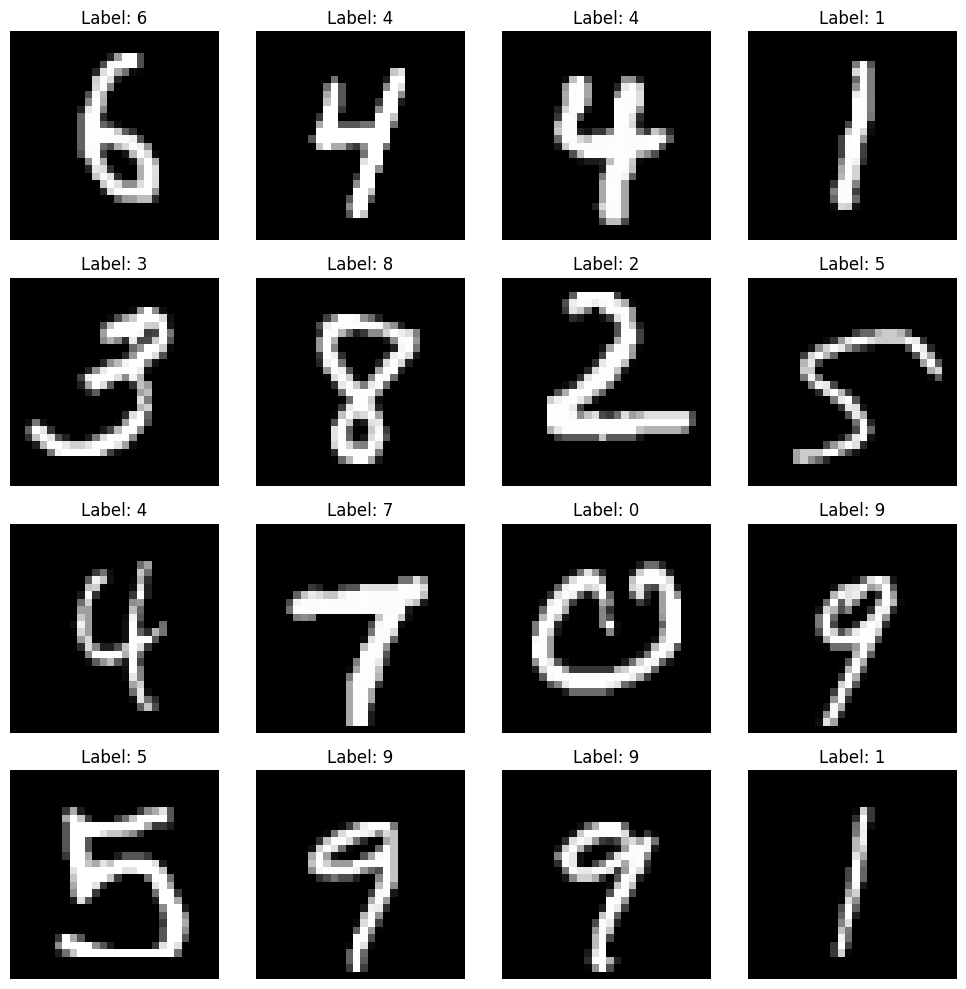

In [80]:
# Visualizar imágenes aleatorias del dataset
images, labels = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    imshow(images[i])
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()

<ipython-input-81-c02e7020b3c2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels_series, palette='viridis')


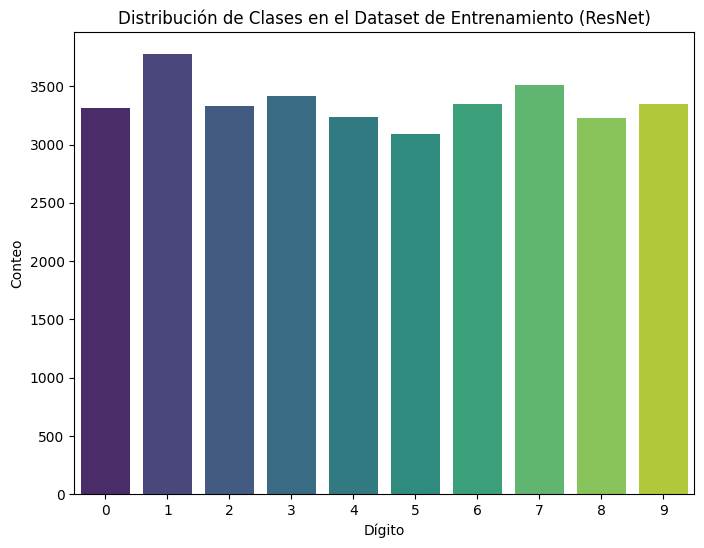

In [81]:
# Ver distribución de etiquetas en el conjunto de entrenamiento
train_labels_series = pd.Series([label.item() for _, label in train_subset])
plt.figure(figsize=(8, 6))
sns.countplot(x=train_labels_series, palette='viridis')
plt.title("Distribución de Clases en el Dataset de Entrenamiento (ResNet)")
plt.xlabel("Dígito")
plt.ylabel("Conteo")
plt.savefig(os.path.join(base_output_path, 'class_distribution_resnet.png')) # Guardar la gráfica
plt.show()

In [82]:
# Ver un batch de datos para inspeccionar las dimensiones
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostrar dimensiones del dataset
print("\n--- Dimensiones del Dataset ---")
print("Tamaño del dataset de entrenamiento (total):", len(full_train_dataset))
print("Tamaño del subset de entrenamiento (para modelo):", len(train_subset_torch))
print("Tamaño del subset de validación:", len(val_subset_torch))
print("Tamaño del dataset de prueba:", len(test_dataset_torch))
print("Dimensiones de una imagen (C x H x W):", images[0].shape)
print("Tamaño del batch (número de imágenes por batch):", images.shape[0])
print("Número total de batches en el train_loader:", len(train_loader))
print("Número total de batches en el val_loader:", len(val_loader))
print("Número total de batches en el test_loader:", len(test_loader_torch))


--- Dimensiones del Dataset ---
Tamaño del dataset de entrenamiento (total): 42000
Tamaño del subset de entrenamiento (para modelo): 33600
Tamaño del subset de validación: 8400
Tamaño del dataset de prueba: 28000
Dimensiones de una imagen (C x H x W): torch.Size([1, 28, 28])
Tamaño del batch (número de imágenes por batch): 64
Número total de batches en el train_loader: 525
Número total de batches en el val_loader: 132
Número total de batches en el test_loader: 438


In [83]:
#Sobreescribir metricas del modelo de Red Neuronal Convolucional
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [84]:
#Sobreescribir metricas del modelo ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [85]:

# --- Funciones de Entrenamiento genal para los medelos utilizados en la solucion de este laboratorio
def train_pytorch_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, model_name, output_path):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)
    print(f"\nIniciando entrenamiento para {model_name}...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_running_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Validation Loss: {val_losses[-1]:.4f}, Validation Acc: {val_accuracies[-1]:.2f}%")

    print(f"Entrenamiento de {model_name} finalizado.")

    # Guardar métricas
    metrics_df = pd.DataFrame({
        'Epoch': range(1, epochs + 1),
        'Train_Loss': train_losses,
        'Train_Accuracy': train_accuracies,
        'Validation_Loss': val_losses,
        'Validation_Accuracy': val_accuracies
    })
    excel_path = os.path.join(output_path, f'{model_name.replace(" ", "_").lower()}_training_metrics.xlsx')
    metrics_df.to_excel(excel_path, index=False)
    print(f"\nMétricas de entrenamiento para {model_name} guardadas en: {excel_path}")

    # Graficar curvas de pérdida y precisión
    plot_metrics_curves(train_losses, val_losses, "Loss", model_name, epochs, output_path)
    plot_metrics_curves(train_accuracies, val_accuracies, "Accuracy", model_name, epochs, output_path)
    plot_scatter_metrics(train_losses, val_losses, "Loss", model_name, epochs, output_path)
    plot_scatter_metrics(train_accuracies, val_accuracies, "Accuracy", model_name, epochs, output_path)

    return model

In [86]:
# --- Nombres de las clases (dígitos) ---
class_names = [str(i) for i in range(10)]


           MODELO 1: Red Neuronal Convolucional (CNN)

Iniciando entrenamiento para CNN...
Epoch 1/4, Train Loss: 0.6117, Train Acc: 92.85%, Validation Loss: 0.0857, Validation Acc: 97.13%
Epoch 2/4, Train Loss: 0.0773, Train Acc: 97.65%, Validation Loss: 0.0746, Validation Acc: 97.52%
Epoch 3/4, Train Loss: 0.0558, Train Acc: 98.25%, Validation Loss: 0.0755, Validation Acc: 98.06%
Epoch 4/4, Train Loss: 0.0450, Train Acc: 98.62%, Validation Loss: 0.0872, Validation Acc: 97.57%
Entrenamiento de CNN finalizado.

Métricas de entrenamiento para CNN guardadas en: drive/MyDrive/Colab Notebooks/red_convolucional_data/cnn_training_metrics.xlsx


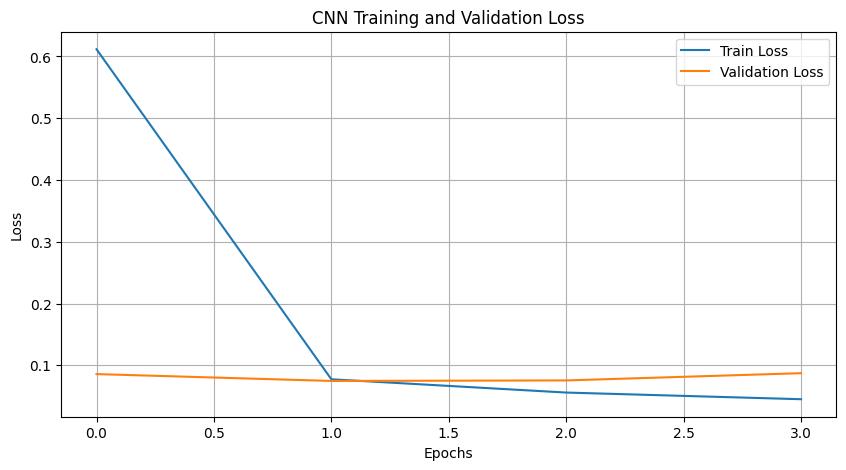

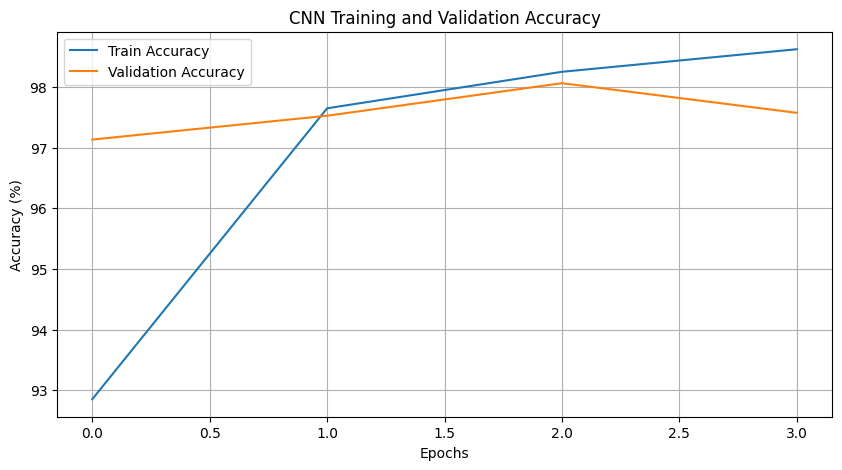

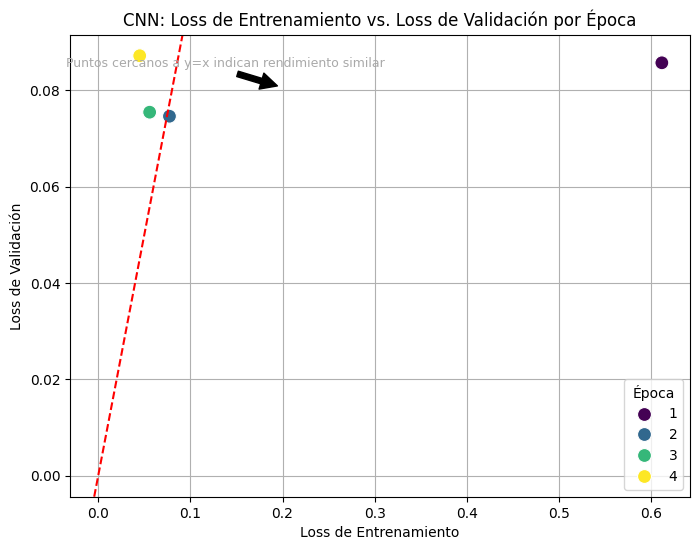

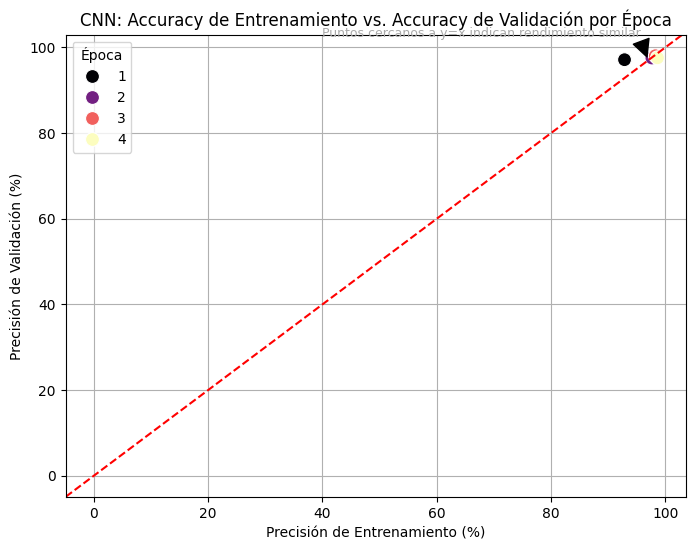

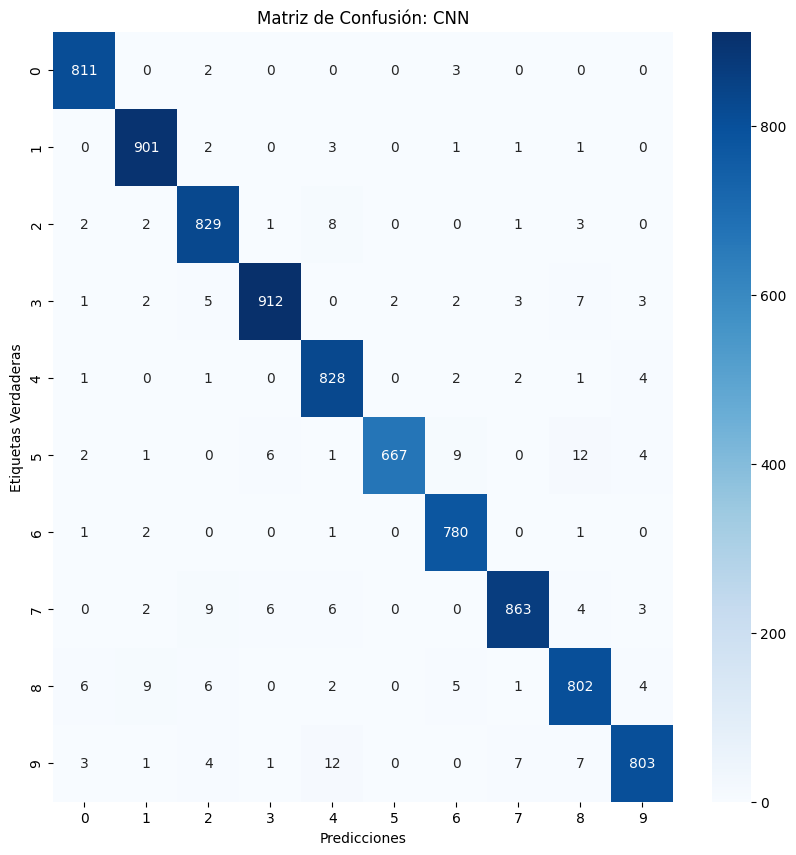

Reporte de Clasificación (CNN):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       816
           1       0.98      0.99      0.99       909
           2       0.97      0.98      0.97       846
           3       0.98      0.97      0.98       937
           4       0.96      0.99      0.97       839
           5       1.00      0.95      0.97       702
           6       0.97      0.99      0.98       785
           7       0.98      0.97      0.97       893
           8       0.96      0.96      0.96       835
           9       0.98      0.96      0.97       838

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400

Precisión General (CNN): 0.9757
Reporte de clasificación guardado en: drive/MyDrive/Colab Notebooks/red_convolucional_data/cnn_classification_report.txt
Archivo de envío para CNN guardado como drive/MyDrive/Co

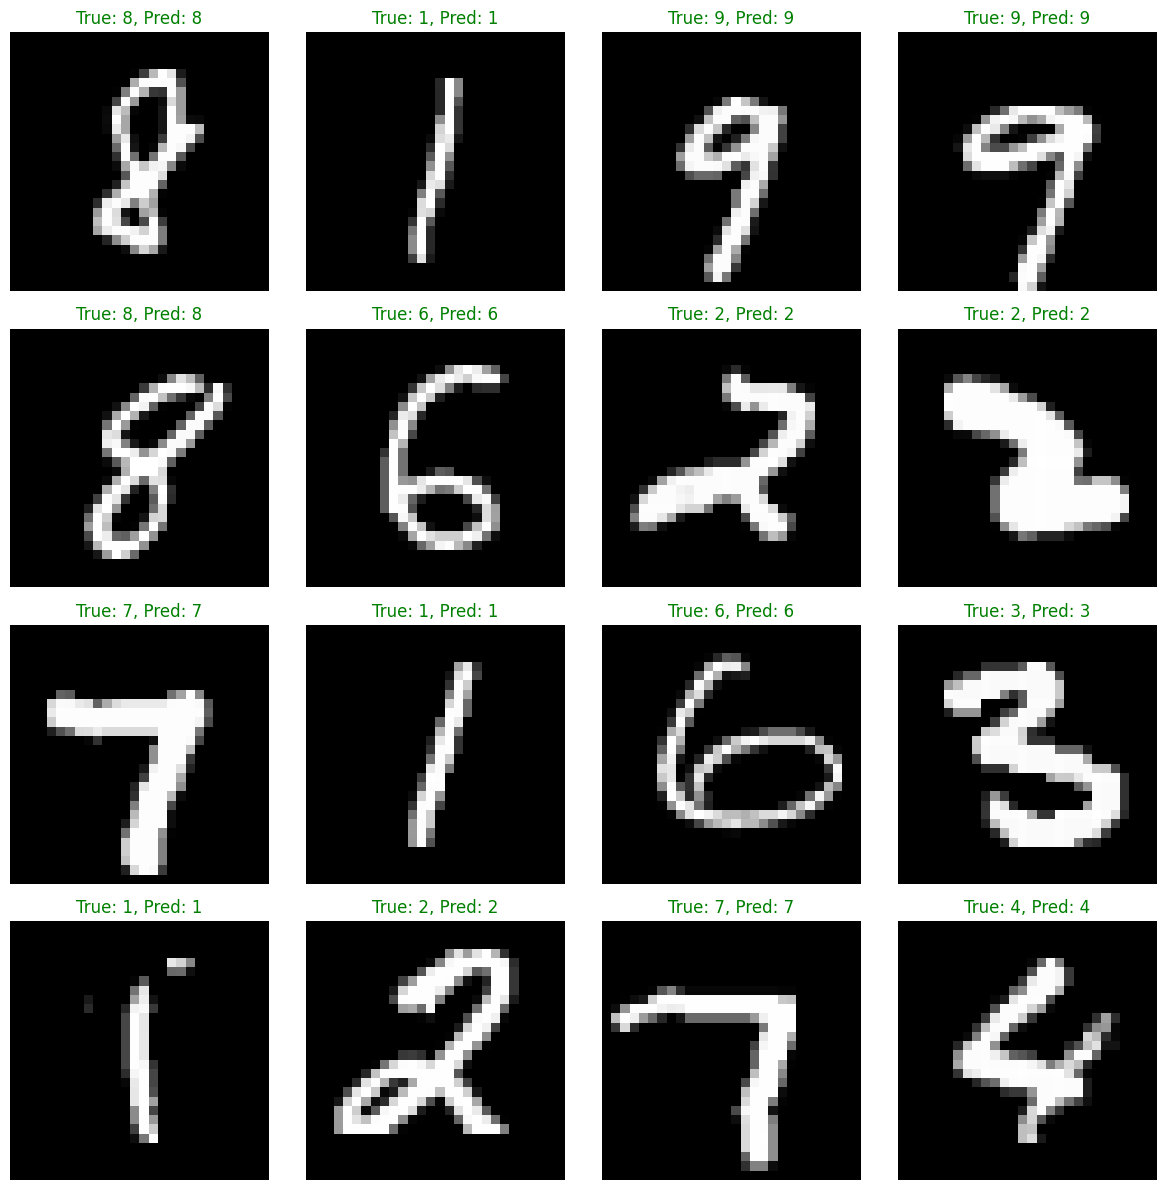

In [87]:
# --- MODELO 1: Red Neuronal Convolucional (CNN) ---
print("\n" + "="*50)
print("           MODELO 1: Red Neuronal Convolucional (CNN)")
print("="*50)

cnn_model = CNN()
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)
epochs_cnn = 4

cnn_model = train_pytorch_model(cnn_model, train_loader, val_loader, criterion_cnn, optimizer_cnn, epochs_cnn, device, "CNN", base_output_path)

# Evaluación de la CNN
evaluate_and_plot_results(cnn_model, val_loader, device, class_names, "CNN", base_output_path)

# Generar archivo de envío para la CNN
generate_submission_file(cnn_model, test_loader_torch, device, "CNN", base_output_path)

# Visualizar algunas predicciones de la CNN en el conjunto de validación
cnn_model.eval()
images_to_show, labels_to_show = next(iter(val_loader))
images_to_show_dev = images_to_show.to(device) # Mover a device antes de pasar al modelo

with torch.no_grad():
    outputs_show = cnn_model(images_to_show_dev)
    _, predictions_show = torch.max(outputs_show, 1)

plt.figure(figsize=(12, 12))
for i in range(min(16, images_to_show.size(0))):
    plt.subplot(4, 4, i + 1)
    imshow(images_to_show[i].cpu())
    true_label = labels_to_show[i].item()
    predicted_label = predictions_show[i].item()
    plt.title(f"True: {true_label}, Pred: {predicted_label}",
              color="green" if true_label == predicted_label else "red")
    plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(base_output_path, 'cnn_sample_predictions.png'))
plt.show()

# --- Preparación de Datos para modelos Scikit-learn ---
# Para K-NN, Random Forest, SVM, necesitamos aplanar las imágenes de píxeles
# y no usaremos los DataLoaders de PyTorch directamente para el entrenamiento/validación
# sino los arrays de numpy.

# Cargar los datos originales (no transformados por ToTensor/Normalize) para Scikit-learn
train_data_skl = pd.read_csv(os.path.join(base_output_path, 'train.csv'))
test_data_skl = pd.read_csv(os.path.join(base_output_path, 'test.csv'))

X_skl = train_data_skl.drop('label', axis=1).values / 255.0 # Normalizar píxeles
y_skl = train_data_skl['label'].values
X_test_skl = test_data_skl.values / 255.0 # Normalizar píxeles

# Dividir el conjunto de entrenamiento para Scikit-learn
X_train_skl, X_val_skl, y_train_skl, y_val_skl = train_test_split(X_skl, y_skl, test_size=0.2, random_state=42)

# Crear un "loader" simple para Scikit-learn que imite la estructura para `evaluate_model`
# Esto es una lista de tuplas (X_batch, y_batch)
skl_val_loader = [(X_val_skl, y_val_skl)] # Pasamos el conjunto de validación completo como un solo "batch" para simplicidad
skl_test_loader = [(X_test_skl)] # Para el test, solo las imágenes


         MODELO 2: K-Nearest Neighbors (K-NN)
Entrenando modelo K-NN...
Modelo K-NN entrenado.


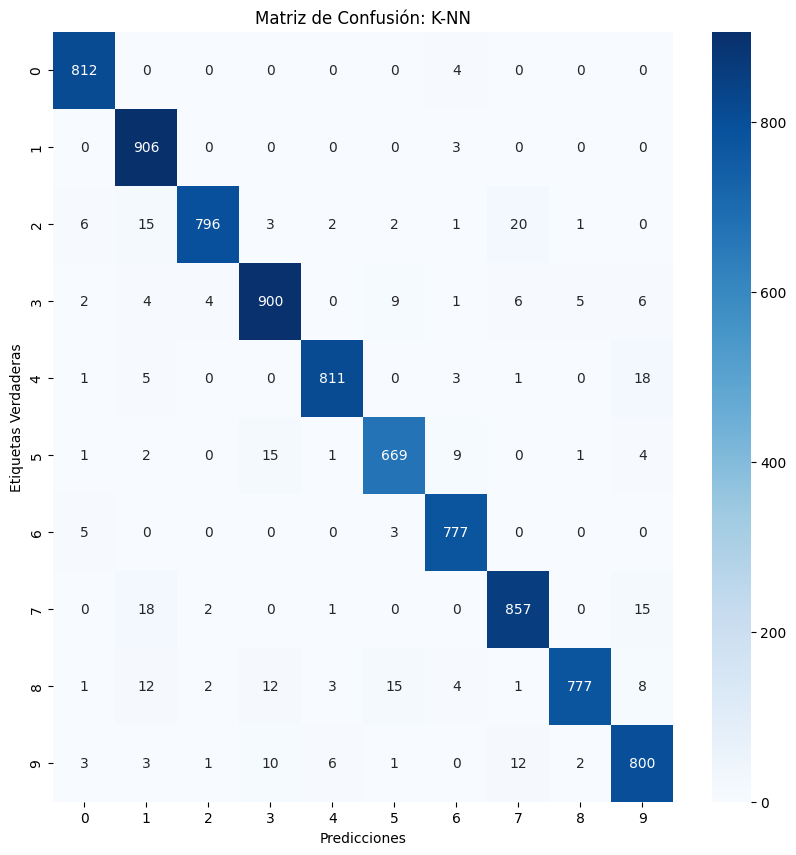

Reporte de Clasificación (K-NN):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       816
           1       0.94      1.00      0.97       909
           2       0.99      0.94      0.96       846
           3       0.96      0.96      0.96       937
           4       0.98      0.97      0.98       839
           5       0.96      0.95      0.96       702
           6       0.97      0.99      0.98       785
           7       0.96      0.96      0.96       893
           8       0.99      0.93      0.96       835
           9       0.94      0.95      0.95       838

    accuracy                           0.96      8400
   macro avg       0.97      0.96      0.96      8400
weighted avg       0.97      0.96      0.96      8400

Precisión General (K-NN): 0.9649
Reporte de clasificación guardado en: drive/MyDrive/Colab Notebooks/red_convolucional_data/k-nn_classification_report.txt
Archivo de envío para K-NN guardado como drive/MyDriv

In [88]:


# --- MODELO 2: K-Nearest Neighbors (K-NN) ---
print("\n" + "="*50)
print("         MODELO 2: K-Nearest Neighbors (K-NN)")
print("="*50)

knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Entrenando modelo K-NN...")
knn_model.fit(X_train_skl, y_train_skl)
print("Modelo K-NN entrenado.")

# Evaluación de K-NN
evaluate_and_plot_results(knn_model, skl_val_loader, device, class_names, "K-NN", base_output_path, is_pytorch_model=False)
#evaluate_model(knn_model, skl_val_loader, device, class_names, "K-NN", base_output_path, is_pytorch_model=False)

# Generar archivo de envío para K-NN
generate_submission_file(knn_model, skl_test_loader, device, "K-NN", base_output_path, is_pytorch_model=False)



            MODELO 3: Random Forest
Entrenando modelo Random Forest...
Modelo Random Forest entrenado.


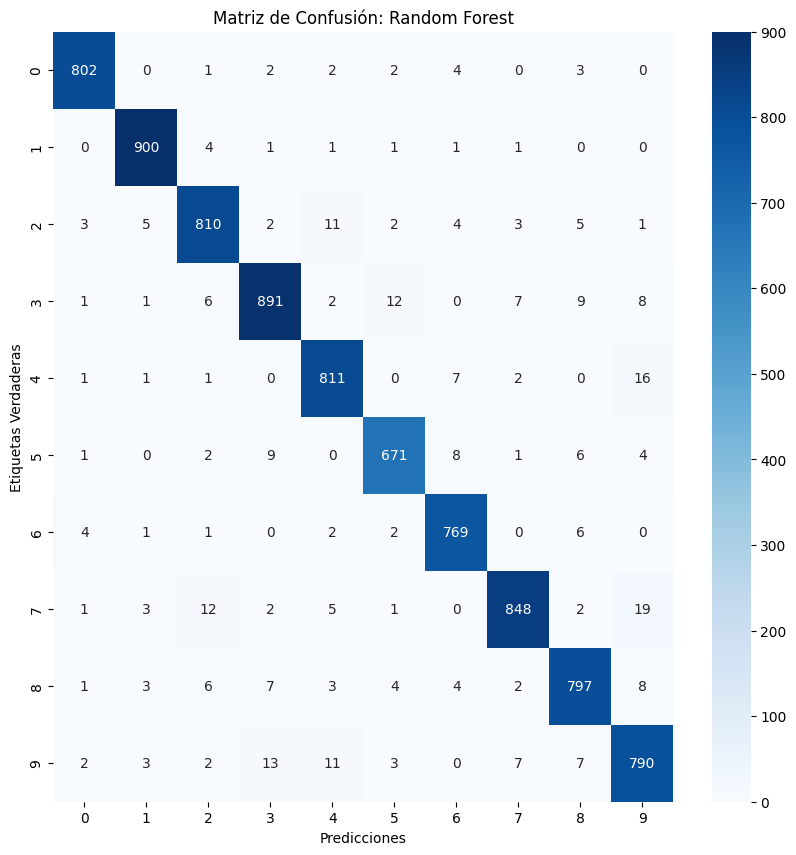

Reporte de Clasificación (Random Forest):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       816
           1       0.98      0.99      0.99       909
           2       0.96      0.96      0.96       846
           3       0.96      0.95      0.96       937
           4       0.96      0.97      0.96       839
           5       0.96      0.96      0.96       702
           6       0.96      0.98      0.97       785
           7       0.97      0.95      0.96       893
           8       0.95      0.95      0.95       835
           9       0.93      0.94      0.94       838

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400

Precisión General (Random Forest): 0.9630
Reporte de clasificación guardado en: drive/MyDrive/Colab Notebooks/red_convolucional_data/random_forest_classification_report.txt
Archivo de envío para Rand

In [89]:
# --- MODELO 3: Random Forest ---
print("\n" + "="*50)
print("            MODELO 3: Random Forest")
print("="*50)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Entrenando modelo Random Forest...")
rf_model.fit(X_train_skl, y_train_skl)
print("Modelo Random Forest entrenado.")

# Evaluación de Random Forest
evaluate_and_plot_results(rf_model, skl_val_loader, device, class_names, "Random Forest", base_output_path, is_pytorch_model=False)
#evaluate_model(rf_model, skl_val_loader, device, class_names, "Random Forest", base_output_path, is_pytorch_model=False)

# Generar archivo de envío para Random Forest
generate_submission_file(rf_model, skl_test_loader, device, "Random Forest", base_output_path, is_pytorch_model=False)



          MODELO 4: Support Vector Machine (SVM)
Entrenando modelo SVM en un subconjunto de 10000 muestras...
Modelo SVM entrenado.


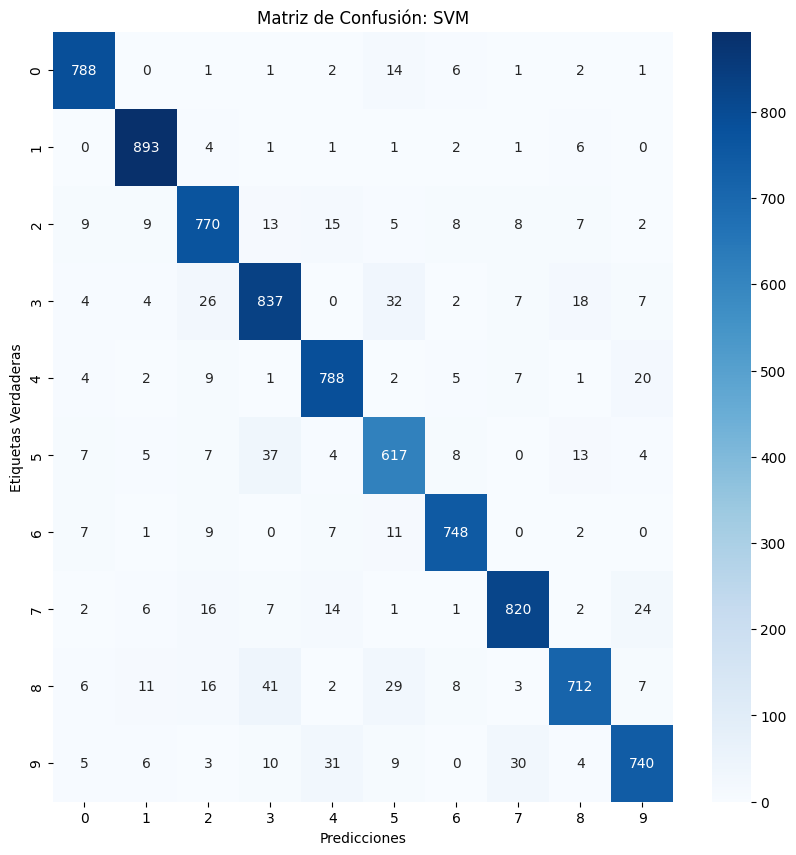

Reporte de Clasificación (SVM):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       816
           1       0.95      0.98      0.97       909
           2       0.89      0.91      0.90       846
           3       0.88      0.89      0.89       937
           4       0.91      0.94      0.93       839
           5       0.86      0.88      0.87       702
           6       0.95      0.95      0.95       785
           7       0.94      0.92      0.93       893
           8       0.93      0.85      0.89       835
           9       0.92      0.88      0.90       838

    accuracy                           0.92      8400
   macro avg       0.92      0.92      0.92      8400
weighted avg       0.92      0.92      0.92      8400

Precisión General (SVM): 0.9182
Reporte de clasificación guardado en: drive/MyDrive/Colab Notebooks/red_convolucional_data/svm_classification_report.txt
Archivo de envío para SVM guardado como drive/MyDrive/Co

In [90]:


# --- MODELO 4: Support Vector Machine (SVM) ---
print("\n" + "="*50)
print("          MODELO 4: Support Vector Machine (SVM)")
print("="*50)

# Submuestreo para SVM para una ejecución más rápida (puedes ajustar o quitar)
sample_size_svm = 10000 # Aumentado a 10000 para una mejor representación
X_train_svm_sub = X_train_skl[:sample_size_svm]
y_train_svm_sub = y_train_skl[:sample_size_svm]

print(f"Entrenando modelo SVM en un subconjunto de {sample_size_svm} muestras...")
svm_model = SVC(kernel='linear', random_state=42, verbose=False) # 'verbose=True' si quieres ver el progreso
svm_model.fit(X_train_svm_sub, y_train_svm_sub)
print("Modelo SVM entrenado.")

# Evaluación de SVM
evaluate_and_plot_results(svm_model, skl_val_loader, device, class_names, "SVM", base_output_path, is_pytorch_model=False)
#evaluate_model(svm_model, skl_val_loader, device, class_names, "SVM", base_output_path, is_pytorch_model=False)

# Generar archivo de envío para SVM
generate_submission_file(svm_model, skl_test_loader, device, "SVM", base_output_path, is_pytorch_model=False)



        MODELO 5: ResNet-like (Convolucional)

Iniciando entrenamiento para ResNet...
Epoch 1/4, Train Loss: 0.2236, Train Acc: 94.51%, Validation Loss: 0.0703, Validation Acc: 97.94%
Epoch 2/4, Train Loss: 0.0546, Train Acc: 98.34%, Validation Loss: 0.0466, Validation Acc: 98.52%
Epoch 3/4, Train Loss: 0.0412, Train Acc: 98.81%, Validation Loss: 0.0953, Validation Acc: 97.24%
Epoch 4/4, Train Loss: 0.0337, Train Acc: 99.01%, Validation Loss: 0.0373, Validation Acc: 98.80%
Entrenamiento de ResNet finalizado.

Métricas de entrenamiento para ResNet guardadas en: drive/MyDrive/Colab Notebooks/red_convolucional_data/resnet_training_metrics.xlsx


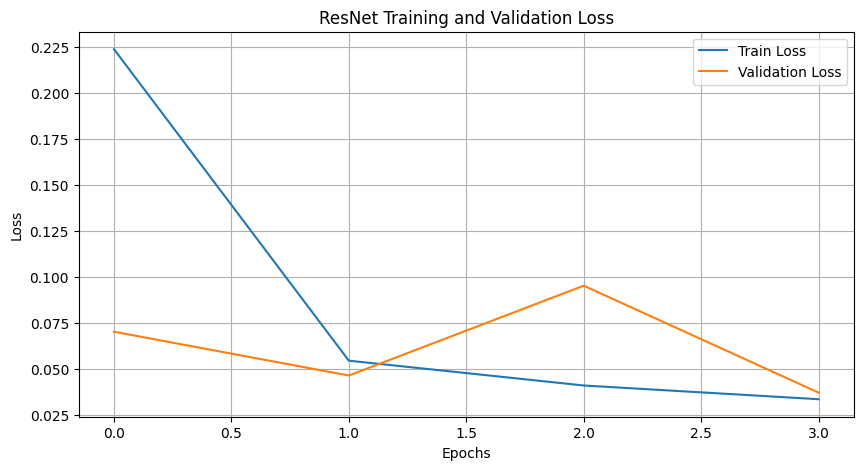

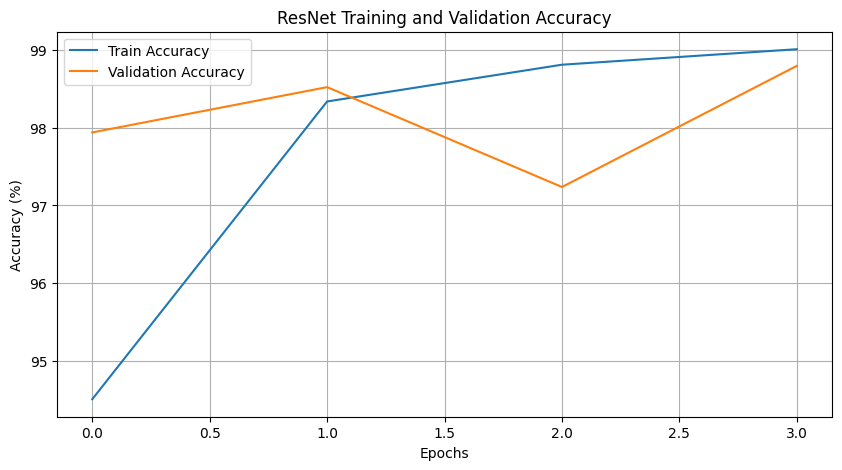

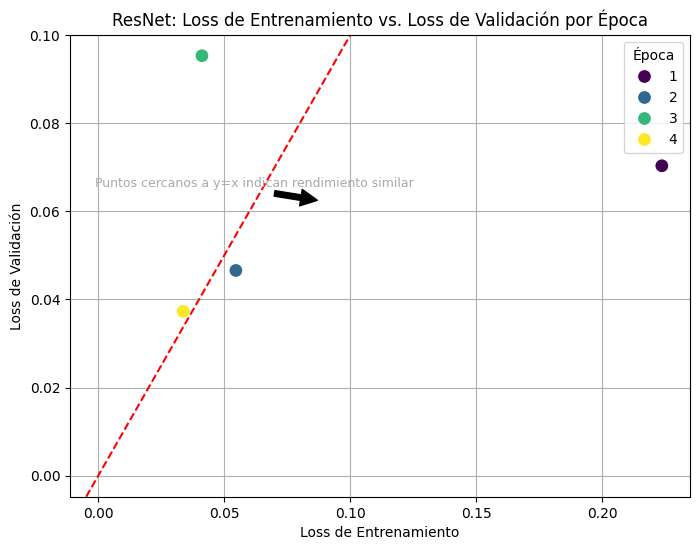

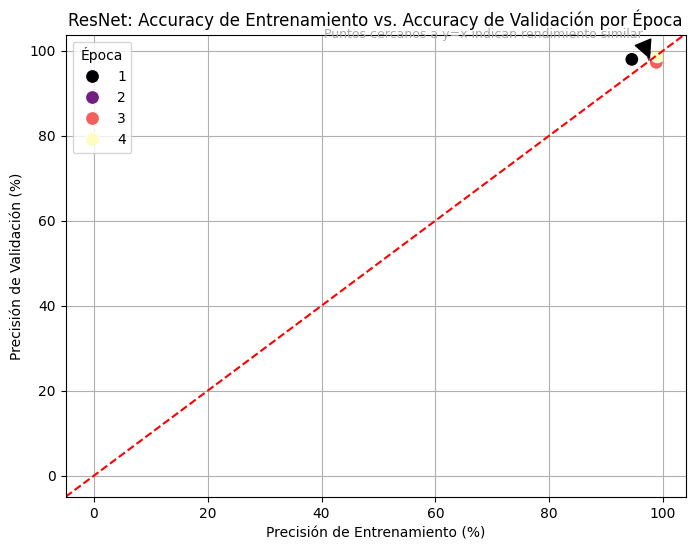

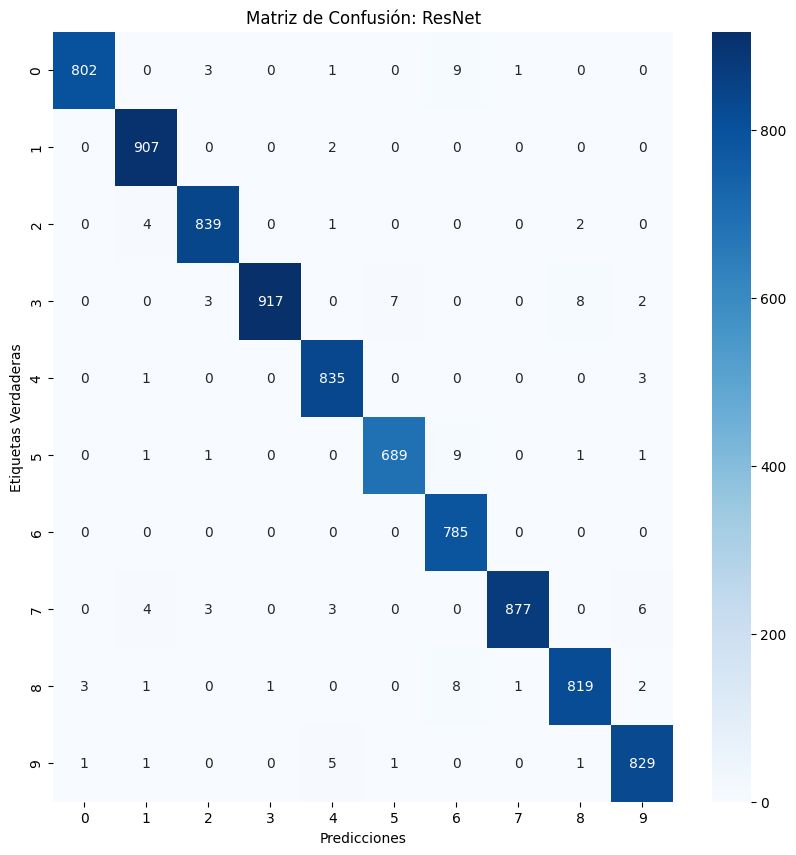

Reporte de Clasificación (ResNet):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       816
           1       0.99      1.00      0.99       909
           2       0.99      0.99      0.99       846
           3       1.00      0.98      0.99       937
           4       0.99      1.00      0.99       839
           5       0.99      0.98      0.98       702
           6       0.97      1.00      0.98       785
           7       1.00      0.98      0.99       893
           8       0.99      0.98      0.98       835
           9       0.98      0.99      0.99       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400

Precisión General (ResNet): 0.9880
Reporte de clasificación guardado en: drive/MyDrive/Colab Notebooks/red_convolucional_data/resnet_classification_report.txt
Archivo de envío para ResNet guardado como driv

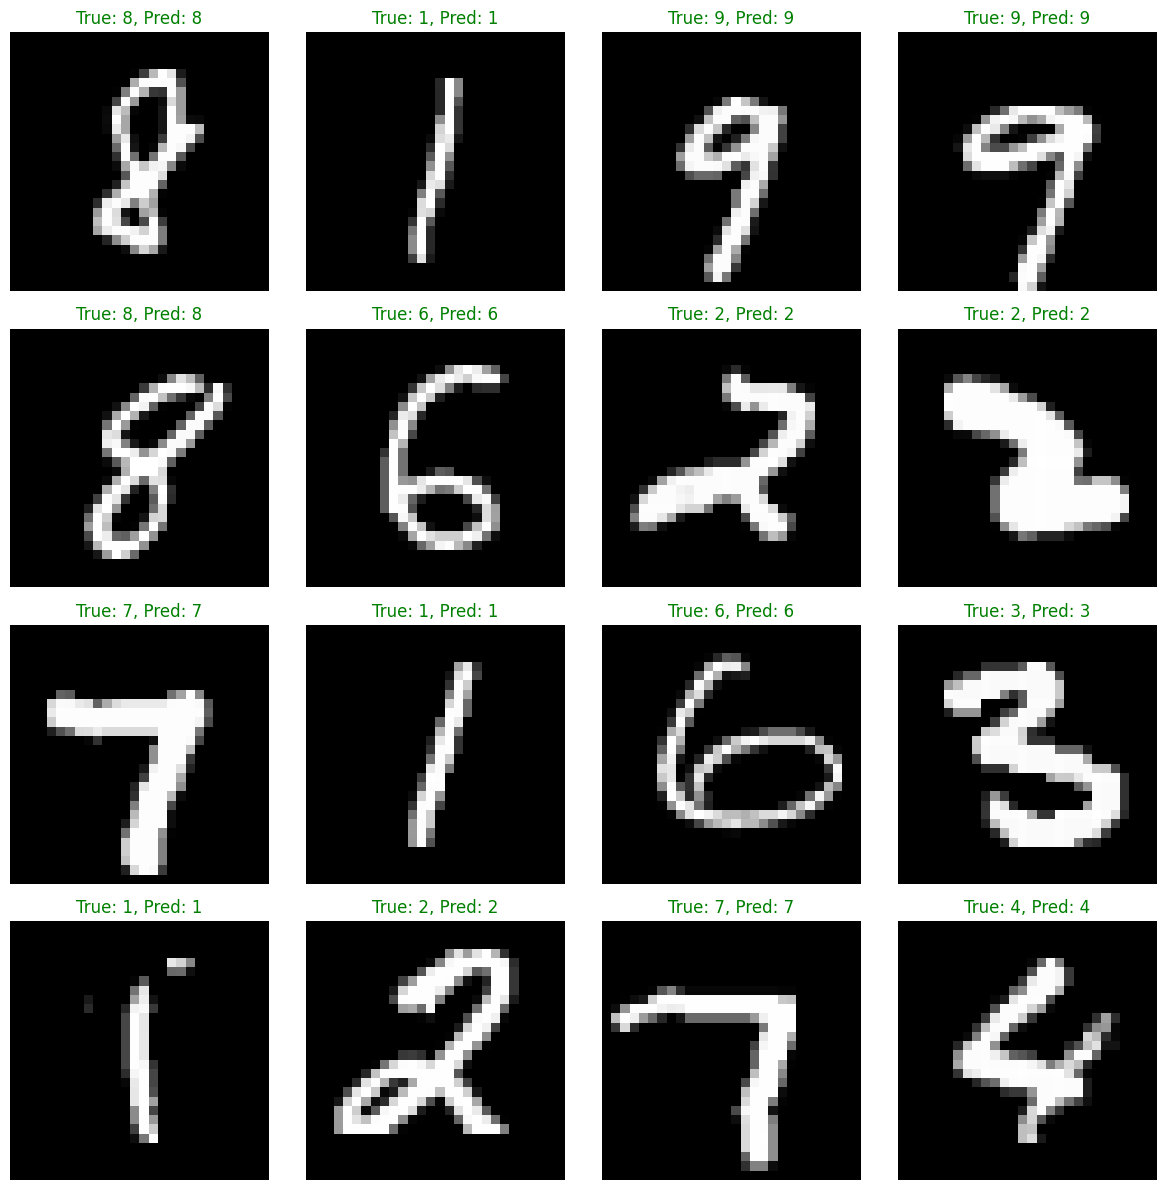

In [91]:
# --- MODELO 5: ResNet-like (Convolucional con Bloques Residuales) ---
print("\n" + "="*50)
print("        MODELO 5: ResNet-like (Convolucional)")
print("="*50)

resnet_model = ResNet(ResidualBlock, [2, 2, 2]) # Puedes ajustar los bloques [2, 2, 2]
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.001)
epochs_resnet = 4 # Puedes aumentar las épocas para mejor rendimiento

resnet_model = train_pytorch_model(resnet_model, train_loader, val_loader, criterion_resnet, optimizer_resnet, epochs_resnet, device, "ResNet", base_output_path)

# Evaluación de ResNet
evaluate_and_plot_results(resnet_model, val_loader, device, class_names, "ResNet", base_output_path)
#evaluate_model(resnet_model, val_loader, device, class_names, "ResNet", base_output_path)

# Generar archivo de envío para ResNet
generate_submission_file(resnet_model, test_loader_torch, device, "ResNet", base_output_path)

# Visualizar algunas predicciones de ResNet en el conjunto de validación
resnet_model.eval()
images_to_show_resnet, labels_to_show_resnet = next(iter(val_loader))
images_to_show_resnet_dev = images_to_show_resnet.to(device)

with torch.no_grad():
    outputs_show_resnet = resnet_model(images_to_show_resnet_dev)
    _, predictions_show_resnet = torch.max(outputs_show_resnet, 1)

plt.figure(figsize=(12, 12))
for i in range(min(16, images_to_show_resnet.size(0))):
    plt.subplot(4, 4, i + 1)
    imshow(images_to_show_resnet[i].cpu())
    true_label = labels_to_show_resnet[i].item()
    predicted_label = predictions_show_resnet[i].item()
    plt.title(f"True: {true_label}, Pred: {predicted_label}",
              color="green" if true_label == predicted_label else "red")
    plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(base_output_path, 'resnet_sample_predictions.png'))
plt.show()